In [1]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
from keras_tqdm import TQDMNotebookCallback
import random
import matplotlib.pyplot as plt
import numpy as np
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

import os
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [2]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [3]:
dog_image_id = os.listdir('images/dog')[0]
dog_image = load_image(os.path.join('images/dog',dog_image_id))
print(f'shape: {dog_image.shape}')
print(f'type: {type(dog_image)}')
model.predict(dog_image)

shape: (1, 224, 224, 3)
type: <class 'numpy.ndarray'>


array([[1.35573508e-09, 5.99931411e-08, 9.20550233e-11, 1.71286353e-11,
        1.02184554e-08, 4.84360712e-08, 1.78620463e-09, 8.86349483e-08,
        5.39433138e-08, 1.31212008e-09, 1.85974301e-07, 1.60849282e-07,
        4.11535828e-09, 3.72753242e-08, 4.16471835e-09, 1.18441026e-08,
        3.26067564e-08, 2.81094549e-06, 2.95590041e-08, 1.10414177e-07,
        9.33889233e-09, 1.51557451e-08, 1.08574975e-10, 9.77062982e-08,
        7.82517802e-08, 1.77400195e-09, 1.58039093e-08, 2.83834778e-09,
        3.34051453e-09, 1.79423909e-09, 1.11508669e-09, 3.26373737e-08,
        3.49717877e-09, 1.54686944e-07, 5.08961016e-08, 1.91509102e-08,
        7.09428605e-08, 2.63284594e-08, 7.08181780e-09, 1.18241035e-08,
        8.32812308e-09, 1.47281956e-08, 2.01150407e-09, 1.08447793e-08,
        2.73470219e-10, 6.58545559e-07, 2.41848355e-08, 4.33564118e-08,
        1.51051324e-07, 7.53410598e-11, 1.18069415e-10, 4.28928137e-09,
        8.24407476e-09, 7.56759544e-10, 2.46361553e-09, 1.276217

In [4]:
model = tf.keras.applications.mobilenet.MobileNet(
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

In [5]:
dog_image_id = os.listdir('images/dog')[0]
dog_image = load_image(os.path.join('images/dog',dog_image_id))
model.predict(dog_image).shape

(1, 1024)

In [6]:
x = Dropout(rate=0.4)(model.output)
x = Dense(2)(x)
x = Softmax()(x)
model= Model(model.inputs, x)

In [7]:
for layer in model.layers[:-3]:
    layer.trainable = False
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy'
)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=_mobilenet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

ensure_folder_exists('training_aug')
training = datagen.flow_from_directory( 
    './images', 
    target_size=(224, 224),
    save_to_dir='./training_aug',
    subset='training'
) 

ensure_folder_exists('validation_aug')
validation = datagen.flow_from_directory( 
    './images',
    target_size=(224, 224),
    save_to_dir='./validation_aug',
    subset='validation'
) 

Found 114 images belonging to 2 classes.
Found 11 images belonging to 2 classes.


In [8]:
from keras_tqdm import TQDMNotebookCallback

batch_size = 32

history = model.fit(
    x=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=10,
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

Epoch 1/10
3/3 [==============================] - 4s 907ms/step - loss: 0.7537
Epoch 2/10
3/3 [==============================] - 3s 952ms/step - loss: 0.5949
Epoch 3/10
3/3 [==============================] - 3s 986ms/step - loss: 0.4926
Epoch 4/10
3/3 [==============================] - 3s 992ms/step - loss: 0.4969
Epoch 5/10
3/3 [==============================] - 3s 722ms/step - loss: 0.3488
Epoch 6/10
3/3 [==============================] - 2s 695ms/step - loss: 0.3241
Epoch 7/10
3/3 [==============================] - 3s 957ms/step - loss: 0.2506
Epoch 8/10
3/3 [==============================] - 3s 724ms/step - loss: 0.2935
Epoch 9/10
3/3 [==============================] - 3s 771ms/step - loss: 0.2404
Epoch 10/10
3/3 [==============================] - 3s 945ms/step - loss: 0.0889


KeyError: 'val_loss'

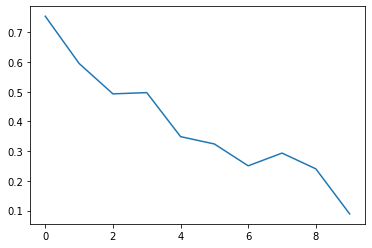

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
random_cat = random.choice(os.listdir('images/cat/'))
cat_path = os.path.join('images/cat',random_cat)
cat = load_image(cat_path)
random_dog = random.choice(os.listdir('images/dog/'))
dog_path = os.path.join('images/dog',random_dog)
dog = load_image(dog_path)
tf.keras.preprocessing.image.load_img(cat_path, target_size=(224,224))
tf.keras.preprocessing.image.load_img(dog_path, target_size=(224,224))
print(f'''cat:{np.round(model.predict(cat),2)}''')
print(f'''dog:{np.round(model.predict(dog),2)}''')


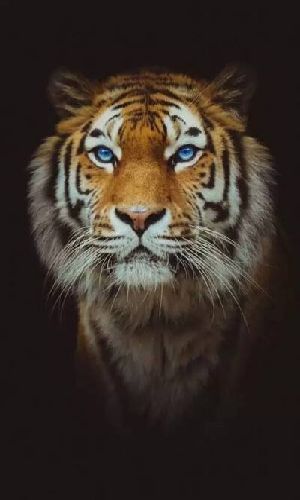

In [12]:
tiger_path = 'tiger.jpg'
tiger = load_image(tiger_path)
tf.keras.preprocessing.image.load_img(tiger_path, target_size=(500,300))

In [13]:
print(f'''tiger:{np.round(model.predict(tiger),2)}''')

tiger:[[0.74 0.26]]
